# About This Notebook

importing cleaned and preprocessed data and outputting production model 

### Import Libraries

In [2]:
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# SKLearn Model Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# SKLearn Metric Libraries
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, auc, f1_score
from sklearn import metrics

### Read in Data
* Reading in data from EDA and preprocessing notebook. It has been cleaned from stop words, symbols, numbers and contractions. 

In [3]:
posts_df = pd.read_csv('../data/03_preprocessed_df.csv')

In [4]:
posts_df.head(1)

,selftext,subreddit
0,resources newbie home winemaker comprehensive ...,winemaking


### Creating Target and Predictor variables. 
* X is the 'selftext' (posts) column
* Count Vectorizer expects a series object and not a dataframe object to be passed into X. 
* y is the binarized 'subreddit' column

In [5]:
X = posts_df['selftext']
y = posts_df['subreddit']

In [6]:
y = y.map({'winemaking': 0, 'Homebrewing' : 1})

In [7]:
X.shape

(4302,)

In [8]:
y.shape

(4302,)

### Train/Test/Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = .30, 
                                                   stratify = y, 
                                                   random_state = 42)

### Checking Mean Baseline Accuracy
#### Interpretation of Baseline Accuracy Score (below)
* Randomly guessing that a post is from Homebrewing would be right about 55% of the time.

#### Interpretation of Baseline Balanced Accuracy Score
* Randomly guessing that a post is from Homebrewing would make correct guesses 27.5% of the time. 

In [10]:
baseline = y_test.value_counts(normalize = True)
baseline

1    0.549961
0    0.450039
Name: subreddit, dtype: float64

In [11]:
def baseline_balanced_accuracy(tn, tp, fn, fp):
    
    # function that takes in the true p, n and false p,n and returns balanced accuracy score
    total_pred = tn + tp + fn + fp
    recall_score = round((tp / (fn + tp) * 100) , ndigits = 1)
    balanced_accuracy = 1/2* (recall_score + (tn/total_pred))
    print(f'Baseline Balanced Accuracy Score: {balanced_accuracy}%')

* Function created by me but formula came from post below. 
*https://datascience.stackexchange.com/questions/73974/balanced-accuracy-vs-f1-score#:~:text=One%20major%20difference%20is%20that,many%20negatives%20you%20labeled%20correctly.


In [12]:
# See interpretation above
baseline_balanced_accuracy(tn = 0, tp = 55, fn = 45, fp = 0)

Baseline Balanced Accuracy Score: 27.5%


In [13]:
# Fit the vectorizer on our corpus Train Data
cvec = CountVectorizer(stop_words = 'english', min_df = 2)

In [14]:
# Transform the corpus
cvec.fit(X_train)

CountVectorizer(min_df=2, stop_words='english')

In [15]:
Z_train = cvec.transform(X_train)

In [16]:
# Transform but do not fit test data
Z_test = cvec.transform(X_test)

# Running other models with default parameters to measure against the baseline. 

In [17]:
logr_clf = LogisticRegression(max_iter = 10_000)
forest_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC()
knn_clf = KNeighborsClassifier(n_neighbors=5)
mnb_clf = MultinomialNB()
ada_clf = AdaBoostClassifier()

In [18]:
classifiers = [logr_clf, forest_clf, svc_clf, knn_clf, mnb_clf, ada_clf]

In [19]:
for clf in classifiers:
    clf.fit(Z_train, y_train)
    
    y_pred = clf.predict(Z_train)
    
    # Score model on training set
    
    training_score = round((clf.score(Z_train, y_train) * 100), ndigits = 1)
        
    if clf == forest_clf:
        print(f' Random Forest Score on Training Set: {training_score}%')
    if clf == svc_clf:
        print(f' SVC Score on Training Set: {training_score}%')
    if clf == knn_clf:
        print(f' Nearest Neighbors Score on Training Set: {training_score}%')
    if clf == mnb_clf:
        print(f' Naive Bayes Score on Training Set: {training_score}%')
    if clf == ada_clf:
        print(f' Ada Boost Score on Training Set: {training_score}%')
    if clf == logr_clf:
        print(f' Logistic Regression Score on Training Set: {training_score}%')
        

    # Score model on testing set
    test_score = round((clf.score(Z_test, y_test) * 100), ndigits = 1)
        
    if clf == forest_clf:
        print(f' Random Forest Score on Testing Set: {test_score}%')
    if clf == svc_clf:
        print(f' SVC Score on Testing Set: {test_score}%')
    if clf == knn_clf:
        print(f' Nearest Neighbors Score on Testing Set: {test_score}%')
    if clf == mnb_clf:
        print(f' Naive Bayes Score on Testing Set: {test_score}%')
    if clf == ada_clf:
        print(f' Ada Boost Score on Testing Set: {test_score}%')
    if clf == logr_clf:
        print(f' Logistic Regression Score on Test Set: {test_score}%')
#         print(f' Baseline Score on Test Set: {}%')

 Logistic Regression Score on Training Set: 99.8%
 Logistic Regression Score on Test Set: 89.0%
 Random Forest Score on Training Set: 100.0%
 Random Forest Score on Testing Set: 87.7%
 SVC Score on Training Set: 97.2%
 SVC Score on Testing Set: 86.8%
 Nearest Neighbors Score on Training Set: 72.4%
 Nearest Neighbors Score on Testing Set: 61.8%
 Naive Bayes Score on Training Set: 94.2%
 Naive Bayes Score on Testing Set: 88.7%
 Ada Boost Score on Training Set: 87.4%
 Ada Boost Score on Testing Set: 85.4%


Analysis of Accuracy Scores:

Scoring first on accuracy in order to get an idea on whether or not these models are in danger of easily overfitting on the data. It appears that all of them are overfitting on training data. Nearest Neighbors is overfitting significantly. 

I am going to run this through all scoring methods on the test data to see what else I can determine. 

**Create Y Preds**

In [20]:
y_pred_logr = logr_clf.predict(Z_test)
y_pred_forest = forest_clf.predict(Z_test)
y_pred_svc = svc_clf.predict(Z_test)
y_pred_knn = knn_clf.predict(Z_test)
y_pred_mnb = mnb_clf.predict(Z_test)

In [21]:
preds_list = [y_pred_forest, y_pred_svc, y_pred_knn, y_pred_mnb]

In [23]:
def clf_metric_scorer(clf_list):
    
    ## Creating Lists to Populate with Scores
    classifier_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    tp_list = []
    acc_list = []
    miss_list = []
    recall_list = []
    spec_list = []
    fpr_list = []
    prec_list = []
    bal_acc_list = []
    f1_score_list = []


    
    for clf in clf_list:
        
        ## for classifier identification column in new DF ##
        classifier_list.append(str(clf))
        
        ## Fit Classifiers ##
        clf.fit(Z_train, y_train)
        
        ## Create Predictions ##
        preds = clf.predict(Z_test)
        
        ## Confusion Matrix ##
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
             
        ## Accuracy ##
        accuracy = round((accuracy_score(y_test, preds) * 100), ndigits = 1)
            
        acc_list.append(accuracy)
            
        ## Misclassification rate ##
        misclass_rate = round((100 - accuracy), ndigits = 3)
            
        miss_list.append(misclass_rate)
            
        ## Recall ##
        recall_score = round((tp / (fn + tp) * 100) , ndigits = 1)
            
        recall_list.append(recall_score)
            
        ## Specificity ##
        specificity = round((tn / (tn + fn) * 100), ndigits= 1)
            
        spec_list.append(specificity)
            
        ## False Positive Rate ##
        fpr = round((fp / (fp + tn) * 100), ndigits = 1)
            
        fpr_list.append(fpr)
            
        ## Precision ##
        precision = round((precision_score(y_test, preds, pos_label = 1) * 100), ndigits = 1)
            
        prec_list.append(precision)
            
        ## Balanced Accuracy Score ##
        total_pred = tn + tp + fn + fp
        balanced_acc = (recall_score + specificity) / 2
    
        bal_acc_list.append(balanced_acc)
        
        ## F1 Score ##
        f1_score = round(2*((precision*recall_score)/(precision+recall_score)), ndigits = 2)
        
        f1_score_list.append(f1_score)
    
    ### Create a Dictionary to be turned into a DF ###
    score_dict = {'clf': classifier_list, 'tn' : tn_list , 'fp' : fp_list, 'fn' : fn_list, 
              'tp' : tp_list , 'accuracy' : acc_list , 'misclass' : miss_list ,
              'recall' : recall_list , 'specificity' : spec_list , 'fpr' : fpr_list, 
              'precision' : prec_list, 'balanced_acc' : bal_acc_list, 'f1_score': f1_score_list}
    
    ### DataFrame Instantiation ###
    metric_df = pd.DataFrame(score_dict)
    
    return metric_df

**Call clf_metric_scorer fuction and name the resulting DF**

In [24]:
clf_metric_scores = clf_metric_scorer(classifiers)

In [25]:
clf_metric_scores

,clf,tn,fp,fn,tp,accuracy,misclass,recall,specificity,fpr,precision,balanced_acc,f1_score
0,LogisticRegression(max_iter=10000),527,54,88,622,89.0,11.0,87.6,85.7,9.3,92.0,86.65,89.75
1,RandomForestClassifier(random_state=42),535,46,113,597,87.7,12.3,84.1,82.6,7.9,92.8,83.35,88.24
2,SVC(),504,77,94,616,86.8,13.2,86.8,84.3,13.3,88.9,85.55,87.84
3,KNeighborsClassifier(),556,25,468,242,61.8,38.2,34.1,54.3,4.3,90.6,44.20,49.55
4,MultinomialNB(),545,36,110,600,88.7,11.3,84.5,83.2,6.2,94.3,83.85,89.13
5,AdaBoostClassifier(),540,41,148,562,85.4,14.6,79.2,78.5,7.1,93.2,78.85,85.63


**Setting clf column as index**

In [26]:
clf = clf_metric_scores['clf']

In [27]:
clf_metric_scores.set_index('clf', inplace = True)

In [28]:
clf_metric_scores

,tn,fp,fn,tp,accuracy,misclass,recall,specificity,fpr,precision,balanced_acc,f1_score
clf,,,,,,,,,,,,
LogisticRegression(max_iter=10000),527,54,88,622,89.0,11.0,87.6,85.7,9.3,92.0,86.65,89.75
RandomForestClassifier(random_state=42),535,46,113,597,87.7,12.3,84.1,82.6,7.9,92.8,83.35,88.24
SVC(),504,77,94,616,86.8,13.2,86.8,84.3,13.3,88.9,85.55,87.84
KNeighborsClassifier(),556,25,468,242,61.8,38.2,34.1,54.3,4.3,90.6,44.20,49.55
MultinomialNB(),545,36,110,600,88.7,11.3,84.5,83.2,6.2,94.3,83.85,89.13
AdaBoostClassifier(),540,41,148,562,85.4,14.6,79.2,78.5,7.1,93.2,78.85,85.63


# Interpreting Testing Scores on all Models. 

I will be measuring success by balanced accuracy score. Because of the data collection and processing techniques used in this this binary classification problem. We have two classes that have fairly similar sizes of samples as well as similarly stratified classes. AND since there is no dire requirement to predict positives over negatives. This score makes sense. 
**The balanced accuracy metric essentially gives half its weight to correctly labeled positives and the other half of its weight to correctly labeled negatives.

All of the models scored reasonably close in Balanced Accuracy Score with one major exception. KNN Classifier score was half of what the rest of the models were achieving. This is because Balanced accuracy accounts for correctly labeled negatives and KNN classifier incorrectly labeled a significantly larger portion of the negatives. 

Because of these findings I will choose the best performers on Balanced accuracy score and throw them into an ensemble VotingClassifer. This will hopefull help them to balance each other out. 

I will also pick the best performing model and introduce that to Grid Searched parameters as well. 

In [30]:
clf_metric_scores['balanced_acc'].sort_values(ascending = False)

clf
LogisticRegression(max_iter=10000)         86.65
SVC()                                      85.55
MultinomialNB()                            83.85
RandomForestClassifier(random_state=42)    83.35
AdaBoostClassifier()                       78.85
KNeighborsClassifier()                     44.20
Name: balanced_acc, dtype: float64

# Comparing ROC/AUC

                                              AUC
LogisticRegression(max_iter=10000)       0.891557
RandomForestClassifier(random_state=42)  0.880836
SVC()                                    0.867538
KNeighborsClassifier()                   0.648908
MultinomialNB()                          0.891554
AdaBoostClassifier()                     0.860491


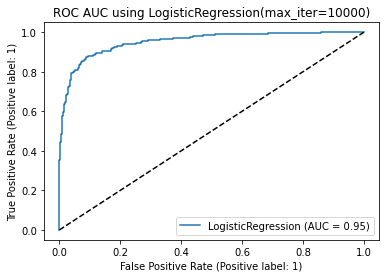

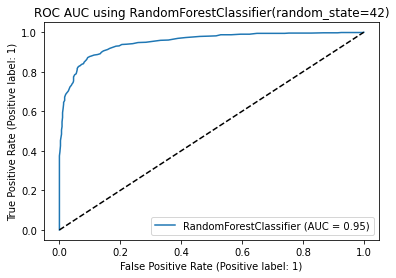

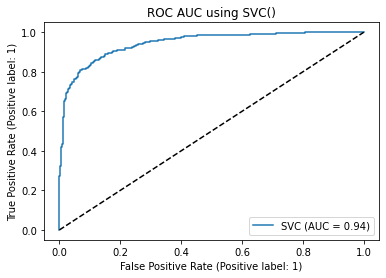

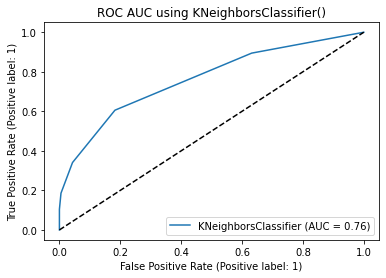

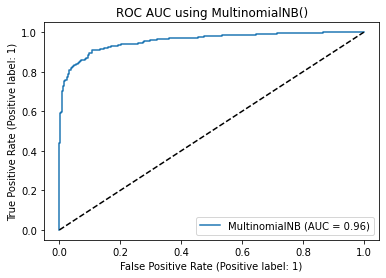

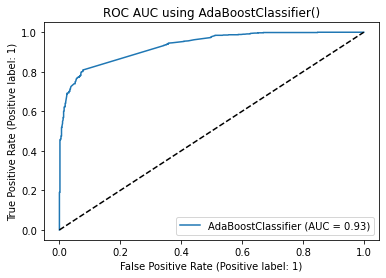

In [31]:
auc_list = []
classifier_list = []

for clf in classifiers:
    
    ## for classifier identification column in new DF ##
    classifier_list.append(str(clf))
    
    ## Fit Classifiers ##
    clf.fit(Z_train, y_train)
        
    ## Create Predictions ##
    pred = clf.predict(Z_test)
        
    fpr, tpr, threshold = roc_curve(y_test, pred, pos_label = 1)
        
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)
        
    plot_roc_curve(clf, Z_test, y_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC AUC using {clf}')
    

auc_df = pd.DataFrame(auc_list, index = classifier_list, columns = ['AUC'])
print(auc_df)

**AREA UNDER THE CURVE INTERPRETATION**

The AUC Curves again look fairly good for all models but the KNN classifier. They're all hugging the top left corner of the chart which indicates that they have a high true positive rate and a lower false positive rate. 

In [32]:
## creating a list of our two chosen vectorizers to iterate through in our grid search
vectorizer = [CountVectorizer(), TfidfVectorizer()]

In [33]:
## creating variables to accept tuning parameters
max_feat = [300, 500]  
ngram_range = [(1, 3), (1, 2)] 
stop_words = [None, 'english'] 
max_df = [0.9, 0.8] 

In [34]:
results = []

## looping through both vectorizers
for vect in vectorizer:
    
    #### Pipeline for our Vectorizer and Classifier Models ####
    pipeline = Pipeline([
        ('vect', vect),
        ('clf', LogisticRegression())])
    
    instantiations = [ #### Beginning of Instantiations List ####
        {
            ### SVC Vect Hyperparameters ###
            
            'vect__max_features': max_feat,
            'vect__stop_words': stop_words,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df,
            
            ## SVC Instantiation and Hyperparameters
            'clf': (SVC(gamma='scale', ), ),
            'clf__kernel': ('rbf', 'poly') 
        }, 
    #######
        
    
        {
            ### Voting Classifier Vect Hyperparameters ###
            'vect__max_features': max_feat,
            'vect__stop_words': stop_words,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df,
            
            ## Instantiating Ensemble Voting Classifier ##
            'clf': (VotingClassifier(estimators=[('lr', LogisticRegression()), 
                                                 ('rf', RandomForestClassifier()), 
                                                 ('ada', AdaBoostClassifier()), 
                                                 ('svc', SVC())],                                           
                                            voting='hard'), )
        }    
                    ] #### end of instantiations list ####
    
    
    #### Grid Search ####
    
    grid_search = GridSearchCV(pipeline, 
                               instantiations,
                               cv=4,
                               n_jobs=-1,
                               verbose=3,
                               return_train_score=True)
    
    #### Output Results ####
    
    ## running an if statement to print the type of vectorizer used
    if vect == vectorizer[0]:
        vect_string = "CountVectorizer"
    
    else:
        vect_string = "Tf-IDF Vectorizer"
    
    ## fitting our model and printing our best scores and parameters
    grid_search.fit(X_train, y_train)
    print(f'''Best score for {vect_string} is: 
    {round(grid_search.best_score_, 4)}
    ''')
    print(grid_search.best_params_)
    print("")
    
    ## appending our cv_results_ to the end of results
    results.append(grid_search.cv_results_)    

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best score for CountVectorizer is: 
    0.8668
    
{'clf': VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('ada', AdaBoostClassifier()), ('svc', SVC())]), 'vect__max_df': 0.9, 'vect__max_features': 500, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best score for Tf-IDF Vectorizer is: 
    0.8715
    
{'clf': VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('ada', AdaBoostClassifier()), ('svc', SVC())]), 'vect__max_df': 0.8, 'vect__max_features': 500, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}



In [35]:
tvec = TfidfVectorizer(max_df= 0.8, max_features= 300, ngram_range= (1, 2), stop_words= 'english')

In [36]:
pipeline = Pipeline([
        ('vect', tvec),
        ('clf', VotingClassifier(estimators=[('lr', LogisticRegression()), 
                                                 ('rf', RandomForestClassifier()), 
                                                 ('ada', AdaBoostClassifier()), 
                                                 ('svc', SVC())] ,voting='hard'))])

In [37]:
params = {'vect__max_features': max_feat,
            'vect__stop_words': stop_words,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df}

In [38]:
grid_search = GridSearchCV(pipeline,
                           params, 
                               cv=4,
                               n_jobs=-1,
                               verbose=3,
                               return_train_score=True)

In [39]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.8,
                                                        max_features=300,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression()),
                                                                     ('rf',
                                                                      RandomForestClassifier()),
                                                                     ('ada',
                                                                      AdaBoostClassifier()),
                                                                     ('svc',

In [48]:
preds = grid_search.predict(X_test)

In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [50]:
recall_score = round((tp / (fn + tp) * 100) , ndigits = 1)

In [51]:
specificity = round((tn / (tn + fn) * 100), ndigits= 1)

In [52]:
balanced_acc = (recall_score + specificity) / 2
balanced_acc

80.65

Balanced Accuracy Score for Voting Classifer scored higher at 91% rate on balanced accuracy. This seems to be acceptable as a successful predictor. 